## Random forrest gump main solution


The random forest gump solution consists on the following:
* Train a Neural Network (resnet) model on the image data to predict each of the three classes
* Train a random forest model on the image data to predict each of the three classes

Once we have both trained, we output the probabilities of each class and compute the average between the two models. The class that has the higher average is the one we predict.

We achieve a validation f1-score of 0.76 with this approach.



In [1]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path
from fastai.vision.all import *
from sklearn.ensemble import RandomForestClassifier

In [2]:
if Path("/kaggle").exists():
    # This is in Kaggle, we need kaggle for GPUs
    initial_path = Path(
        "/kaggle", "input", "deforestation", "train_test_data", "train_test_data"
    )
    input_path = Path("/kaggle", "input", "deforestation")
    output_path = Path("/kaggle", "working")
    df_train = pd.read_csv(input_path / "train.csv")
    df_test = pd.read_csv(input_path / "test.csv")
else:
    # This is in local, if you have GPU you will run it fast, if not, grab a coffee and wait
    initial_path = Path("data") / "train_test_data"
    input_path = Path("data")
    df_train = pd.read_csv(input_path / "train.csv")
    df_test = pd.read_csv(input_path / "test.csv")
    output_path = Path("artifacts")
    output_path.mkdir(exist_ok=True)

# Preprocess data
df_train["short_path"] = df_train["example_path"].apply(lambda x: Path(x).name)
df_test["short_path"] = df_test["example_path"].apply(lambda x: Path(x).name)
train_labels = {row["short_path"]: row["label"] for i, row in df_train.iterrows()}
train_image_path = initial_path / "train"

### Neural network training

In here we training a resnet 50 to predict, based on the image data, the class of each training sample.

We use the fastai library to train the model. We use the default resnet 50 model and train it for 20 epochs

The next lines of code are the necessary setup for the NN model to be trained

In [3]:
def label(file_name):
    return train_labels.get((Path(file_name)).name, 0)

f1_macro = F1Score(average='macro')

In [4]:
# Get image data
base_path = initial_path / "train"
test_path = initial_path / "test"

all_files = get_image_files(str(base_path))

# Image loader
all_dls = ImageDataLoaders.from_path_func(
    base_path,
    all_files,
    label_func=label,
    item_tfms=Resize(224),
    batch_tfms=aug_transforms(size=224),
    valid_pct=0,
)

We can have a look at a batch of images, where we see the class of each image

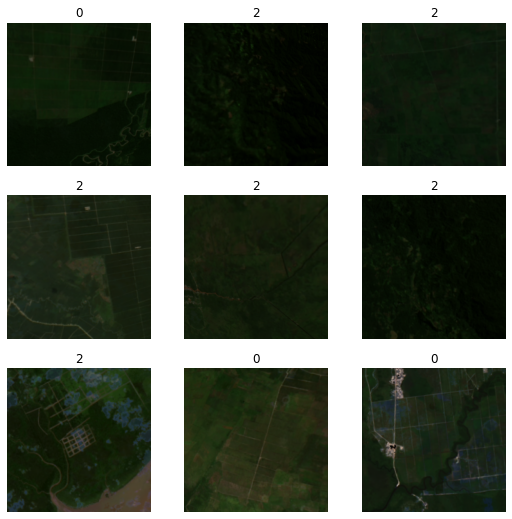

In [5]:
all_dls.show_batch()

Here we create the model, we download data from a resnet 50 pre-trained on imagenet

In [6]:
# Create learner
learn = vision_learner(
    all_dls,
    resnet50,
    metrics=[error_rate, f1_macro],
    model_dir=output_path,
)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

First we find optimal Learning Rate to train the model using learning rate finder function

/opt/conda/lib/python3.7/site-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


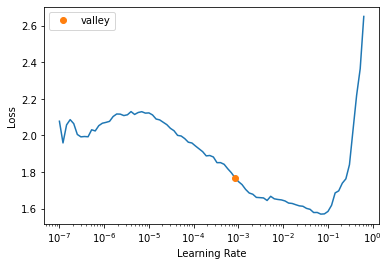

In [7]:
# Find optimal LR
lr = learn.lr_find()

Now we train, using the optimal learning rate, 20 epochs of a resnet 50 model

In [8]:
# Train learner
learn.fine_tune(20, lr.valley)

epoch,train_loss,valid_loss,error_rate,f1_score,time
0,1.437497,None,None,None,00:14


epoch,train_loss,valid_loss,error_rate,f1_score,time
0,1.173861,None,None,None,00:14
1,1.005655,None,None,None,00:15
2,0.963726,None,None,None,00:14
3,0.890793,None,None,None,00:14
4,0.845392,None,None,None,00:15
5,0.793286,None,None,None,00:14
6,0.732357,None,None,None,00:15
7,0.644450,None,None,None,00:14
8,0.570430,None,None,None,00:15
9,0.519707,None,None,None,00:14


## Random forest training

We train using tabular features: latitude, longitude, and year a random forrest model.

In [9]:
# Prepare data for random forrest and train
X_train, y_train = df_train[['latitude','longitude','year']].copy(), df_train.label.copy()
X_test = df_test[['latitude','longitude','year']].copy()

model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

## Test data prediction

We predict individually:
* Random forest model
* Neural network model

We then compute the average of the two predictions and output the class with the highest average.

In [10]:
# Predict random forrest probabilities
test_probas = model.predict_proba(X_test)
rf_probs = pd.DataFrame(test_probas, columns = ['0','1','2'])
rf_probs["short_path"] = df_test["short_path"].values

In [ ]:
# Predict nn probabilities
predictions = {}
scores = {}
for file in test_path.glob('*.png'):
    prediction = learn.predict(file)
    predictions[file.name] = prediction[0]
    scores[file.name] = prediction[2].numpy()

test_scores_nn = pd.DataFrame(scores).T.reset_index().rename(columns={"index": "short_path"})

In [12]:
# Ensemble nn and random forrest
merged_probas = rf_probs.merge(test_scores_nn, how="left")
ensemble_probas = merged_probas[["short_path"]].copy()
ensemble_probas.loc[:, 0] = (merged_probas[0] + merged_probas['0']) / 2
ensemble_probas.loc[:, 1] = (merged_probas[1] + merged_probas['1']) / 2
ensemble_probas.loc[:, 2] = (merged_probas[2] + merged_probas['2']) / 2
ensemble_probas["prediction"] = ensemble_probas.loc[:, [0, 1, 2]].idxmax(axis=1)

## Submission

Prepare submission file

In [14]:
final_test = (
    ensemble_probas
    .assign(short_path=lambda x: x.short_path.str.replace(".png", ""))
    .rename(columns={"prediction": "target"})
    .loc[:, ["short_path", "target"]]
)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


In [15]:
(
    final_test
    .set_index("short_path")
    .to_json(output_path / "predictions.json")
)

In [16]:
final_test.set_index("short_path").to_csv(output_path / "predictions.csv")

Check that ensemble does similar things as individual models

In [17]:
test_scores_nn["prediction"] = test_scores_nn.drop(columns="short_path").idxmax(axis=1)


In [18]:
rf_probs["prediction"] = rf_probs.drop(columns="short_path").idxmax(axis=1)

In [19]:
rf_probs.merge(ensemble_probas, on="short_path").groupby(["prediction_x", "prediction_y"]).size()


prediction_x  prediction_y
0             0               259
              1                 2
              2                67
1             0                18
              1                36
              2                19
2             0                64
              1                 4
              2               166
dtype: int64

In [20]:
test_scores_nn.merge(ensemble_probas, on="short_path").groupby(["prediction_x", "prediction_y"]).size()

prediction_x  prediction_y
0             0               330
              1                 7
              2                 6
1             0                 4
              1                34
              2                 6
2             0                 7
              1                 1
              2               240
dtype: int64

Export model for app

In [ ]:
learn.export(output_path / "model.pkl")
